# Penerapan *Autoencoders* untuk *Occlusion*

### *Import Library* yang Diperlukan

In [1]:
# Import library
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-3de963f4d25a>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


### *Import* dan Proses Data

In [2]:
# Import dataset (dataset yang kita gunakan sudah otomatis tersedia pada Google Colab)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter = ',')

# Menghilangkan labels dari dataset yang akan kita gunakan
data = data[:,1:]

# Melakukan normalisasi sehingga data berada dalam range 0 sampai 1
normalizedData = data / np.max(data)

# Mengubah data hasil normalisasi ke tensor
tensorData = torch.tensor(normalizedData).float()

### Demonstrasi dari Implementasi *Occlusion*

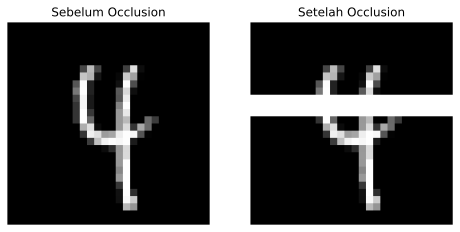

In [3]:
# Merekonstruksi sampel sebagai sebuah image
img = tensorData[12345,:].view(28,28)

occluded = copy.deepcopy( img )
occluded[10:13,:] = 1

fig, ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Sebelum Occlusion')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Setelah Occlusion')
ax[1].axis('off')

plt.show()

### Membuat Model *Deep Learning*

In [4]:
# Membuat sebuah class untuk model
def autoencodersMNIST():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      # Input Layer
      self.input = nn.Linear(784,128)

      # Encoder Layer
      self.enc = nn.Linear(128,50)

      # Latent Layer
      self.lat = nn.Linear(50,128)

      # Decoder Layer
      self.dec = nn.Linear(128,784)

    # Forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # Membuat model instance
  net = aenet()

  # Loss function
  lossfunction = nn.MSELoss()

  # Optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net, lossfunction, optimizer

### Membuat Sebuah *Function* yang akan Melatih Model

In [5]:
def function2trainTheModel():

  # Jumlah epochs
  totalEpochs = 5

  # Membuat sebuah model baru
  net, lossfunction, optimizer = autoencodersMNIST()

  # Menginisialisasi losses
  losses = []

  # Menentukan ukuran dan jumlah batch
  batchsize = 32
  totalBatches = int(tensorData.shape[0]/batchsize)


  # Membuat loop sebanyak jumlah epochs
  for epochs in range(totalEpochs):

    # Menarik nilai permuted index vector
    randomimg = np.random.permutation(tensorData.shape[0]).astype(int)

    for batches in range(totalBatches):

      # Sampel yang digunakan dalam batch ini
      samps2use = range((batches-1)*batchsize,batches*batchsize)

      # Memilih images tersebut
      X = tensorData[randomimg[samps2use],:]

      # Forward pass dan loss function
      yHat = net(X)
      loss = lossfunction(yHat, X)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Loss dalam epoch ini
      losses.append( loss.item() )

  # Epochs berakhir

  # Output dari function
  return losses, net

### Jalankan Model dan Tampilkan Hasilnya

Nilai akhir loss: 0.0125


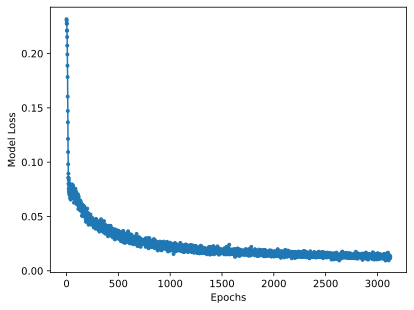

In [6]:
# Melatih data menggunakan model yang telah dibuat (selama 16s)
losses, net = function2trainTheModel()
print(f'Nilai akhir loss: {losses[-1]:.4f}')

# Visualisasi dari jumlah loss
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.show()

## Menambahkan *Occlusion* ke Beberapa *Image*

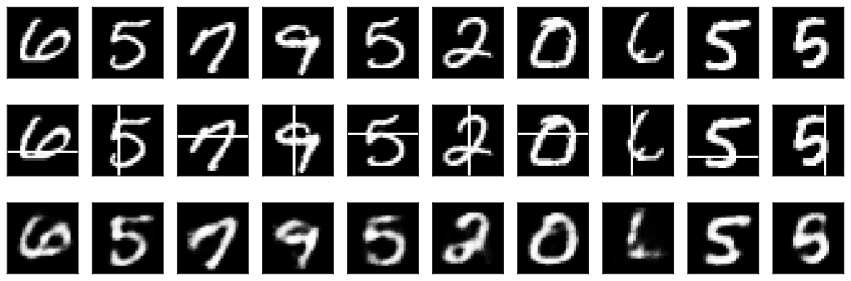

In [7]:
# Buatlah variabel baru berisi sejumlah kecil images
X = copy.deepcopy( tensorData[:10,:] )

# Tambahkan noise pada images tersebut
for i in range(X.shape[0]):

  # Membentuk kembali gambar
  img = X[i,:].view(28,28)

  # Tambahkan occlusion pada baris dan kolom yang dipilih secara random
  startloc = np.random.choice(range(10,21))
  if i%2==0: # jika genap, maka tambahkan occlusion secara horizontal
    img[startloc:startloc+1,:] = 1
  else:      # jika ganjil, maka tambahkan occlusion secara vertikal
    img[:,startloc:startloc+1] = 1

# Masukkan data tersebut ke dalam model
deOccluded = net(X)

# Tampilkan images yang sudah ditambahkan noise
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(tensorData[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.show()

## Sesuatu yang Lebih Kuantitatif

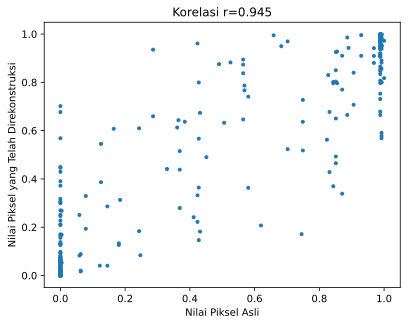

In [8]:
# Kita dapat mengukur kinerja "de-occluder",
# dengan menghubungkan sampel dan aslinya.

inOutCorr = np.corrcoef(tensorData[9,:].detach(),deOccluded[9,:].detach())

# Visualisasi korelasi
plt.plot(tensorData[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Nilai Piksel Asli')
plt.ylabel('Nilai Piksel yang Telah Direkonstruksi')
plt.title(f'Korelasi r={ inOutCorr[0,1] :.3f}')
plt.show()

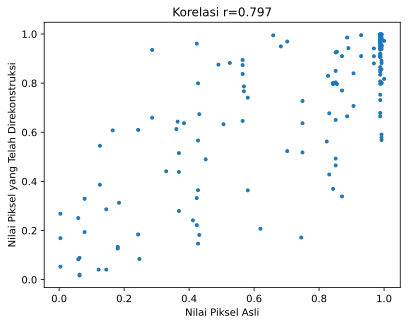

In [9]:
# Coba lagi tanpa piksel yang bernilai nol

# Membagi menjadi beberapa variabel untuk lebih memudahkan
original = tensorData[9,:].detach()
reconstructed = deOccluded[9,:].detach()

# Vektor boolean yang menunjukkan piksel>0,
# (dengan beberapa toleransi)
tolerance = 1e-4
nonzeropixels = (original>tolerance) & (reconstructed>tolerance)

# Menghitung ulang korelasinya
inOutCorr = np.corrcoef(original[nonzeropixels],reconstructed[nonzeropixels])

# Visualisasi korelasi
plt.plot(original[nonzeropixels],reconstructed[nonzeropixels],'.')
plt.xlabel('Nilai Piksel Asli')
plt.ylabel('Nilai Piksel yang Telah Direkonstruksi')
plt.title(f'Korelasi r={ inOutCorr[0,1] :.3f}')
plt.show()

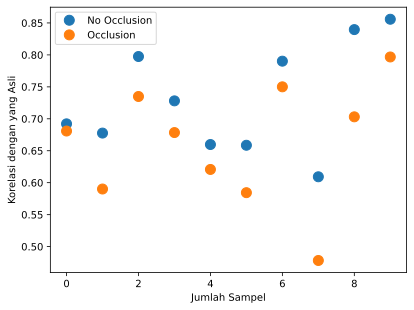

In [10]:
# Tarik data tanpa occlusion
noOcclusion = net(tensorData[:10,:])

# bandingkan korelasi "deOccluded-original",
# dengan "noOcclusion-original"
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # Pemilihan piksel (catatan: nilai tolerance telah dideskripsikan pada cell sebelumnya)
  nonzeropixels = (tensorData[i,:]>tolerance) & (noOcclusion[i,:]>tolerance) & (deOccluded[i,:]>tolerance)

  # Sekarang hitung korelasinya
  r[i,0] = np.corrcoef(tensorData[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(tensorData[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# Visualisasi koefisien korelasi
plt.plot(r,'o',markersize=10)
plt.legend(['No Occlusion','Occlusion'])
plt.xlabel('Jumlah Sampel')
plt.ylabel('Korelasi dengan yang Asli')
plt.show()